## DriftStream API

* How to use the DriftStream API in CapyMOA
* There are two proposals, one of which has been implemented already

**notebook last updated on 09/02/2024**

In [1]:
from capymoa.stream import stream_from_file

DATA_PATH = "./data/"

capymoa_root: /Users/gomeshe/Dropbox/ciencia_computacao/dev/main-projects/CapyMOA/src/capymoa
MOA jar path location (config.ini): /Users/gomeshe/Dropbox/ciencia_computacao/dev/main-projects/CapyMOA/src/capymoa/jar/moa.jar
JVM Location (system): 
JAVA_HOME: /Users/gomeshe/Library/Java/JavaVirtualMachines/openjdk-20.0.1/Contents/Home
JVM args: ['-Xmx8g', '-Xss10M']
Sucessfully started the JVM and added MOA jar to the class path


# 1. Creating a synthetic stream with concept drifts from MOA

* Demonstrates the flexibility of the API, these level of manipulation of the API is expected from experienced MOA users.
* To use the API like this the user must be familiar with how concept drifts are simulatd in MOA

EvaluatePrequential -l trees.HoeffdingAdaptiveTree **-s (ConceptDriftStream -s generators.AgrawalGenerator -d (generators.AgrawalGenerator -f 2) -p 5000)** -e (WindowClassificationPerformanceEvaluator **-w 100**) **-i 10000 -f 100**

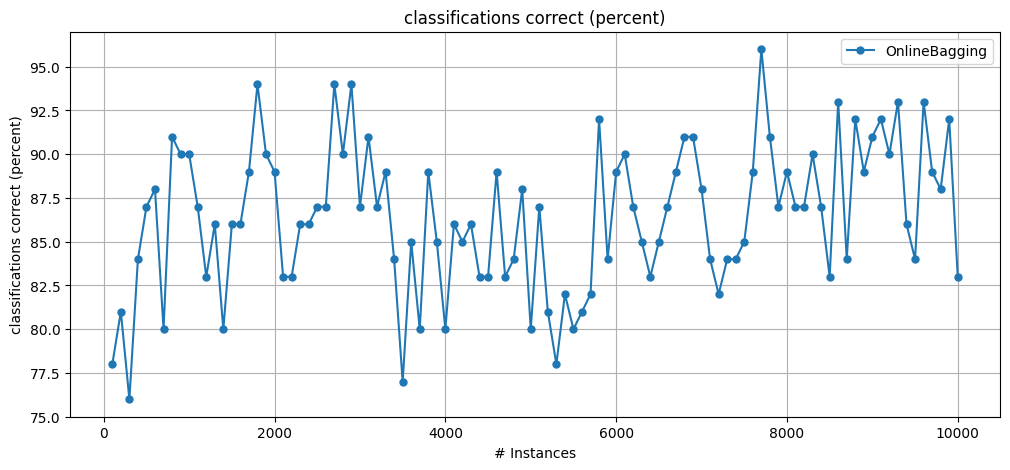

In [2]:
from capymoa.stream.stream import Stream
from capymoa.learner.classifier.classifiers import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from moa.classifiers.bayes import NaiveBayes
from moa.streams import ConceptDriftStream

# Using the API to generate the data using the ConceptDriftStream and AgrawalGenerator.
# The drift location is based on the number of instances (5000) as well as the drift width (1000, the default value) 
stream_sea1drift = Stream(moa_stream=ConceptDriftStream(), 
                          CLI="-s generators.SEAGenerator -d (generators.SEAGenerator -f 2) -p 5000 -w 1000")

OB = OnlineBagging(ensemble_size=10)

results_sea1drift_OB = prequential_evaluation(stream=stream_sea1drift, learner=OB, window_size=100, max_instances=10000)

plot_windowed_results(results_sea1drift_OB)

## 1.1 CapyMOA wrapper for MOA synthetic generators

* This is just an example on how to use a wrapper from CapyMOA

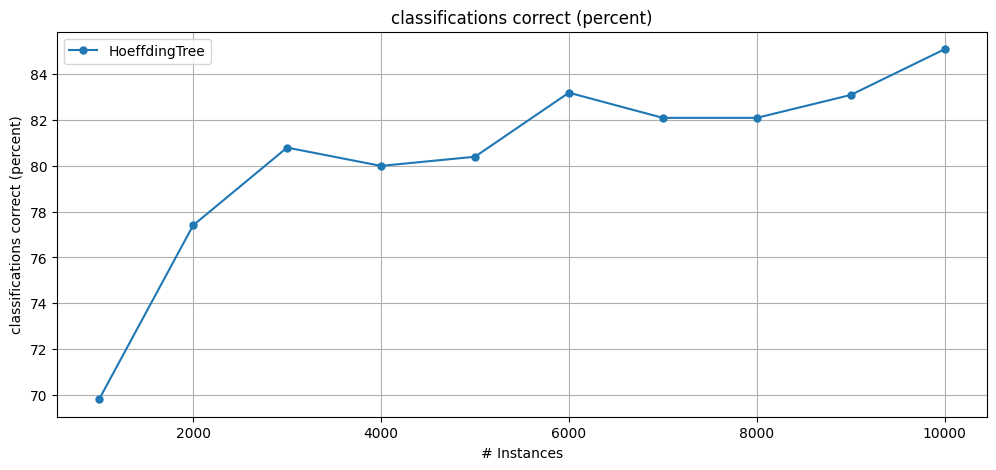

In [3]:
from capymoa.stream.stream import RandomTreeGenerator
from capymoa.learner.classifier.classifiers import MOAClassifier
from moa.classifiers.trees import HoeffdingTree

rtg_stream = RandomTreeGenerator()

ht = MOAClassifier(moa_learner=HoeffdingTree, schema=rtg_stream.get_schema())

results_ht = prequential_evaluation(max_instances=10000, window_size=1000, stream=rtg_stream, learner=ht)

plot_windowed_results(results_ht)

## 2. CapyMOA DriftStream Builder API

* MOA uses a recursive approach to specify concept drift locations like ```CDS(CDS(SEA(1), SEA(2), 1000), SEA(3), 2000)``` where we specify the drift **position** and the **width** of a drift (if it is a Gradual Drift).

  
In CapyMOA, the concepts and drifts are clearly outlined on a list format. There are two ways of specifying a DriftStream in this list format:

1. **```drift position``` + ```drift width```**: the start and end of a concept is determined by the presence of an ```AbruptDrift``` or ```GradualDrift``` object.
   
  <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(position=2000, width=500), SEA(3)]``` -->
  
  **DriftStream([**<span style="color:blue;">SEA(1)</span>, <span style="color:red;">AbruptDrift(position=1000)</span>, <span style="color:blue;">SEA(2)</span>, <span style="color:green;">GradualDrift(<b>position</b>=2000, <b>width</b>=500)</span>, <span style="color:blue;">SEA(3)</span>**])**

  The ```GradualDrift``` can also be specified in terms of ```start``` and ```end```.
  
  <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(start=1750, end=2250), SEA(3)]``` -->
  **DriftStream([**<span style="color:blue;">SEA(1)</span>, <span style="color:red;">AbruptDrift(position=1000)</span>, <span style="color:blue;">SEA(2)</span>, <span style="color:green;">GradualDrift(<b>start</b>=1750, <b>end</b>=2250)</span>, <span style="color:blue;">SEA(3)</span>**])**


2. **```concept num_instances``` + ```drift num_instances```**: the start and end of a concept is determined by the amount of instances generated for it, the same thing can be said about ```GradualDrifts``` which do not have a ```start``` or ```end``` but the number of instances i.e. the ```width``` of that drifting region (or drifting window). Notice that we must prevent users from specifying a drift ```position``` or drift ```start``` and ```end``` when using this version because that would be confusing and error prone. The reason is that the specification of the DriftStream, in this version, doesn't explicitly tells us about the locations of the drifts on the stream, so it is less error prone if we don't allow the user to use this approach mixed with the ```drift position``` one. Example:
   
    <!-- ```[Concept(SEA(1), num_instances=1000), AbruptDrift(), Concept(SEA(2), num_instances=500), GradualDrift(num_instances=500), Concept(SEA(3), num_instances=500)]``` -->
    **DriftStream([**<span style="color:blue;"><b>Concept(</b>SEA(1), num_instances=1000<b>)</b></span>, <span style="color:red;">AbruptDrift()</span>, <span style="color:blue;"><b>Concept(</b>SEA(2), num_instances=500<b>)</b></span>, <span style="color:green;">GradualDrift(num_instances=500)</span>, <span style="color:blue;"><b>Concept(</b>SEA(3), num_instances=500<b>)</b></span>**])**


* Why do we need the **```Concept()```** specification in the **```num_instances```**? The **Stream** class, i.e. base class for **SEA** and other synthetic generators do not implement the concept of a ```max_instances``` or ```num_instances```. If we were to implement that, we would lose compatibility with MOA (where such constraints doesn't exist) and would need to do some extra checkings when generating streams. 
* The **```DriftStream```** specification in the ```position``` + ```width``` version does not specify the total ```size``` of the stream, i.e. notice how the SEA(3) at the end is unbounded, there is no Drift object signaling its end. That is intentional, the user specifying the DriftStream and manipulating it defines the end of the Stream externally. This is true for synthetic streams and also for limiting *snapshot* streams like **electricity** read from a file. 


In [4]:
# DriftStream([(SEA(1), 1000), (SEA(2), 500), GradualDrift(500), (SEA(3), 500)])
# Number of instances as a multipler to the stream source. [1000*SEA(1), …]

### 2.1 DriftStream prelude (the raw MOA version)

* We first show how it is done using MOA's API, so that one can compare it with CapyMOA syntax

In [5]:
from moa.streams import ConceptDriftStream

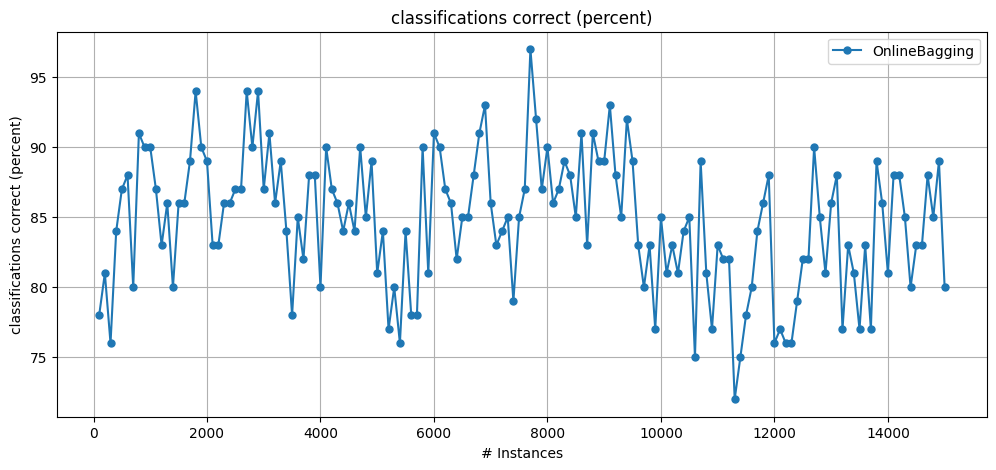

In [6]:
# Pure MOA syntax using the recursive definition for
# SEA(function=1), Drift(position=5000, width=1000), SEA(function=2), Drift(position=10000, width=2000), SEA(function=3)
stream_sea2drift = Stream(moa_stream=ConceptDriftStream(), 
    CLI="-s (ConceptDriftStream -s (generators.SEAGenerator -f 1) -d (generators.SEAGenerator -f 2) -p 5000 -w 1) -d (generators.SEAGenerator -f 3) -p 10000 -w 2000")

OB = OnlineBagging(ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

plot_windowed_results(results_sea2drift_OB)

### 2.2 DriftStream ```position``` + ```width```

* Specifying drift location using the *first* version.

None
[<capymoa.stream.stream.AbruptDrift object at 0x10613d490>, <capymoa.stream.stream.GradualDrift object at 0x16e96fc70>]


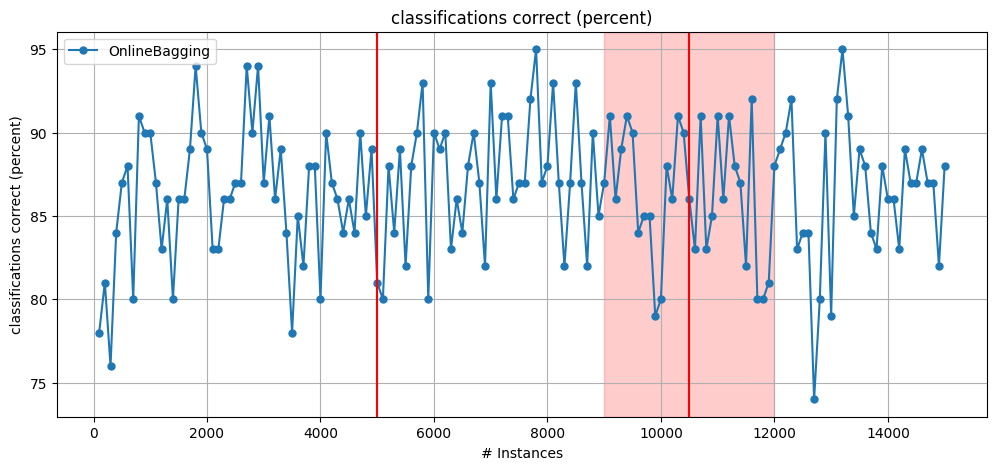

In [7]:
from capymoa.stream.stream import DriftStream, Drift, SEA, AbruptDrift, GradualDrift

stream_sea2drift = DriftStream(stream=[SEA(function=1), 
                                AbruptDrift(position=5000), 
                                SEA(function=3), 
                                # GradualDrift(position=10000, width=2000), 
                                GradualDrift(start=9000, end=12000),
                                SEA(function=1)])

OB = OnlineBagging(ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

print(stream_sea2drift.drifts)
plot_windowed_results(results_sea2drift_OB)

In [8]:
# results_sea2drift_OB['windowed'].metrics_per_window()

In [9]:
print(stream_sea2drift)

SEA(function=1),AbruptDrift(position=5000),SEA(function=3),GradualDrift(position=10500, start=9000, end=12000, width=3000),SEA(function=1)


### 

### 2.2.1 Obtaining meta-data about drift from a MOA Stream

* Besides composing a drifting stream, the DriftStream object also holds information about the Drifts. 
* The meta-data about the drifts can be used for calculating concept drift statistics (i.e. metrics to calculate drift detection performance)

[<capymoa.stream.stream.Drift object at 0x1691c17c0>, <capymoa.stream.stream.Drift object at 0x16e99e3a0>]


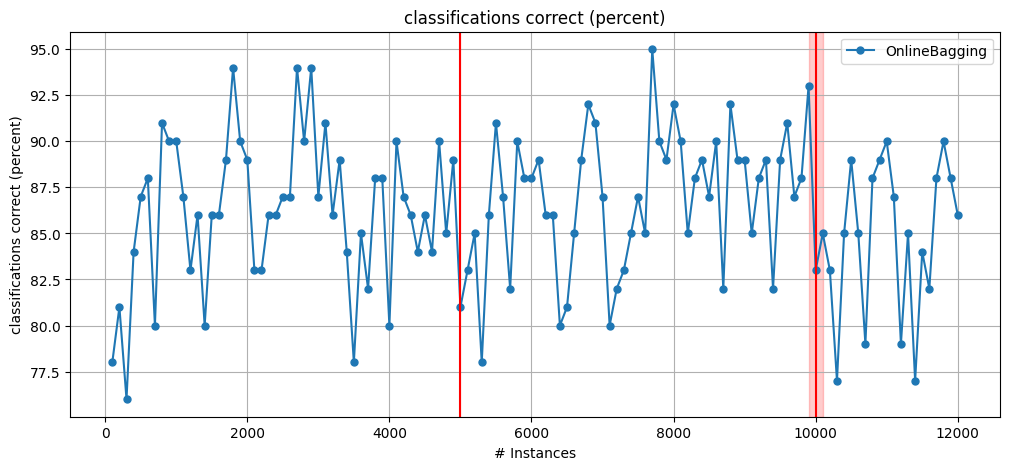

In [10]:
from moa.streams import ConceptDriftStream

stream_sea2drift = DriftStream(moa_stream=ConceptDriftStream(), 
                               CLI='-s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1) \
                               -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0')

OB = OnlineBagging(ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=12000)

print(stream_sea2drift.drifts)
# Notice it works just fine to plot and use the DriftStream created using a MOA object. 
plot_windowed_results(results_sea2drift_OB)

In [11]:
for drift in stream_sea2drift.get_drifts():
    print(drift)

AbruptDrift(position=5000)
GradualDrift(position=10000, width=200)


It is doable to extract drifting information from the ConceptDriftStream MOA objects (precisely the Stream objects that form the concepts) for a proper printing, 
 but that has not been implemented yet (it is a bit cumbersome). So, for the moment, when a DriftStream is specified based on a MOA CLI, we just return the CLI used. 

## 2.3 DriftStream ```range``` 

* This version of the DriftStream builder uses the concept of specfying the number of instances in each concept and drift, i.e. ```concept num_instances``` and ```drift num_instances```

* Still under development! Come back later :)

In [10]:
print(stream_sea2drift)

ConceptDriftStream -s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1)                                -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0
